In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import time
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:02, 3880298.81it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 58230.68it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 968362.99it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 21583.54it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            #Input layer
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            #Second layer
            nn.Linear(1024, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            #Third layer
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            #Final layer - output layer
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        #print(c)
        x = torch.cat((c, x), -1)
        out = self.model(x)
        return out.squeeze()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_embeddings = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            #First layer - Input layer
            nn.Linear(110, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            #Second layer
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            #Third layer
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            #Last layer
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_embeddings(labels)
        #print(c)
        x = torch.cat((c.float(), z.float()), -1)
        out = self.model(x)
        #img = img.view(img.size(0), *img_shape)  
        return out.view(x.size(0), 28, 28)

In [0]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.LongTensor(np.random.normal(0, 1, (batch_size, 100)))).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    #Use for loop to replace step()
    #Or come up with a function to avoid discriminator being trained as well
    g_optimizer.step()
    return g_loss.item()

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size) - 0.1).cuda())
    
    # train with fake images
    z = Variable(torch.LongTensor(np.random.normal(0, 1, (batch_size, 100)))).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size) + 0.2).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [0]:
def getsampleimage(G, n_noise=100):
    """
        save sample 100 images
    """

    z = Variable(torch.LongTensor(np.random.normal(0, 1, (10, 100)))).cuda()
    labels = Variable(torch.LongTensor(np.arange(10))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).cuda()
        c[:, j] = 1
        z = torch.randn(10, n_noise).cuda()
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

Starting epoch 0...
g_loss: 1.2688634395599365, d_loss: 0.962501049041748


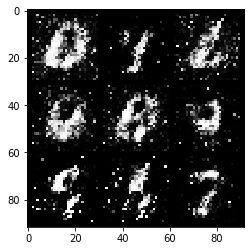

Starting epoch 1...
g_loss: 1.2399359941482544, d_loss: 1.0233913660049438


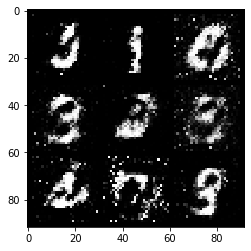

Starting epoch 2...
g_loss: 0.7402544021606445, d_loss: 1.2471721172332764


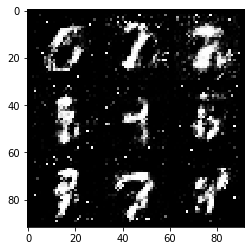

Starting epoch 3...
g_loss: 0.7698301076889038, d_loss: 1.1418960094451904


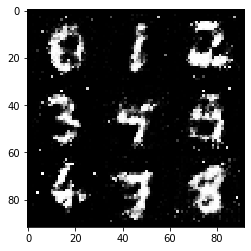

Starting epoch 4...
g_loss: 1.0450239181518555, d_loss: 1.1559133529663086


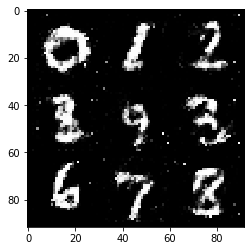

Starting epoch 5...
g_loss: 1.001866340637207, d_loss: 1.1854724884033203


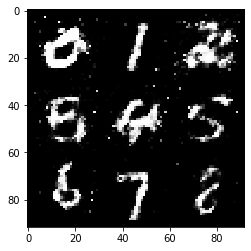

Starting epoch 6...
g_loss: 0.6704097986221313, d_loss: 1.2716022729873657


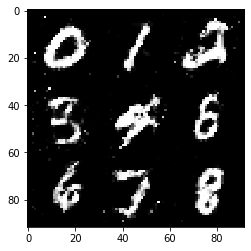

Starting epoch 7...
g_loss: 0.9406900405883789, d_loss: 1.2807118892669678


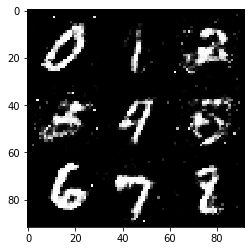

Starting epoch 8...
g_loss: 0.7720476388931274, d_loss: 1.305067539215088


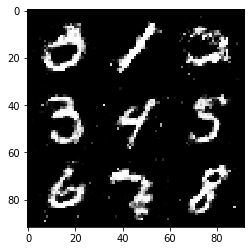

Starting epoch 9...
g_loss: 0.8325822353363037, d_loss: 1.2387657165527344


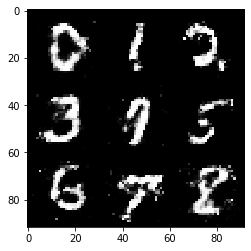

Starting epoch 10...
g_loss: 0.8242015838623047, d_loss: 1.3009727001190186


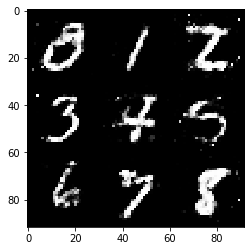

Starting epoch 11...
g_loss: 1.0114247798919678, d_loss: 1.2961269617080688


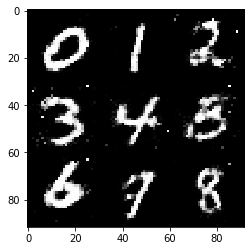

Starting epoch 12...
g_loss: 0.7943285703659058, d_loss: 1.2559473514556885


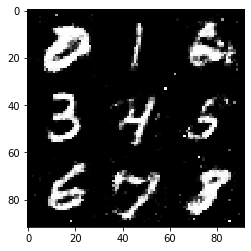

Starting epoch 13...
g_loss: 0.6637678146362305, d_loss: 1.2911581993103027


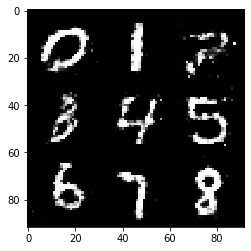

Starting epoch 14...
g_loss: 0.7441799640655518, d_loss: 1.3015990257263184


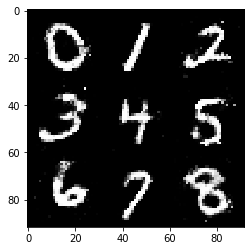

Starting epoch 15...
g_loss: 0.7922760844230652, d_loss: 1.3026621341705322


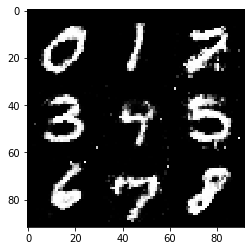

Starting epoch 16...
g_loss: 0.5718805193901062, d_loss: 1.3511512279510498


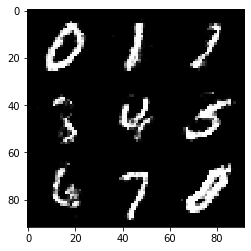

Starting epoch 17...
g_loss: 0.7477551698684692, d_loss: 1.2767093181610107


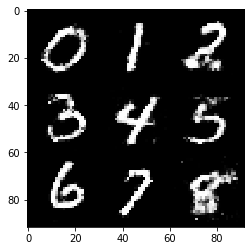

Starting epoch 18...
g_loss: 0.7755358219146729, d_loss: 1.3333194255828857


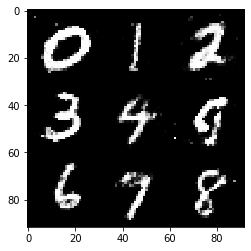

Starting epoch 19...
g_loss: 0.6344573497772217, d_loss: 1.3010666370391846


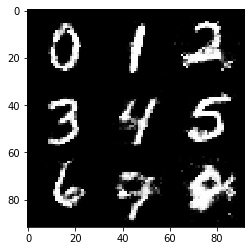

Starting epoch 20...
g_loss: 0.7421510815620422, d_loss: 1.3239541053771973


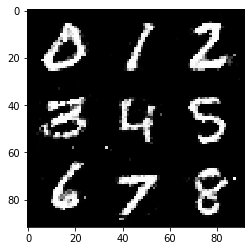

Starting epoch 21...
g_loss: 0.7861422300338745, d_loss: 1.3208026885986328


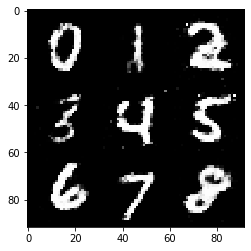

Starting epoch 22...
g_loss: 0.6539381742477417, d_loss: 1.3373441696166992


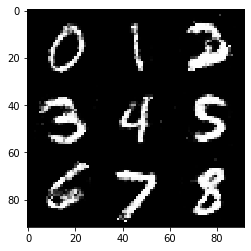

Starting epoch 23...
g_loss: 0.6393610239028931, d_loss: 1.2973992824554443


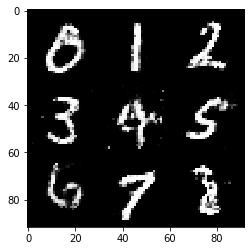

Starting epoch 24...
g_loss: 0.570777177810669, d_loss: 1.2906123399734497


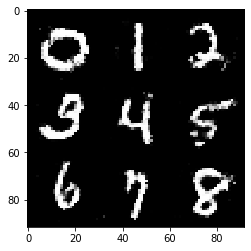

Starting epoch 25...
g_loss: 0.6362899541854858, d_loss: 1.2868660688400269


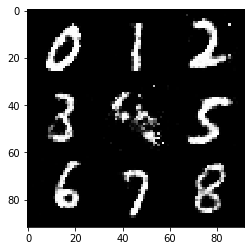

Starting epoch 26...
g_loss: 0.5410133600234985, d_loss: 1.2976372241973877


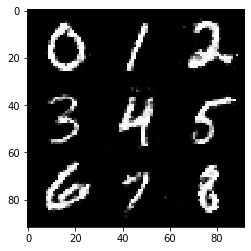

Starting epoch 27...
g_loss: 0.7292584180831909, d_loss: 1.3536523580551147


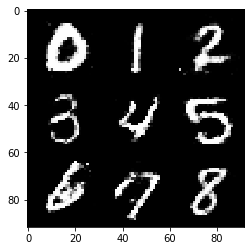

Starting epoch 28...
g_loss: 0.7256488800048828, d_loss: 1.2959164381027222


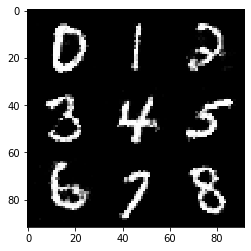

Starting epoch 29...
g_loss: 0.6635252237319946, d_loss: 1.3240752220153809


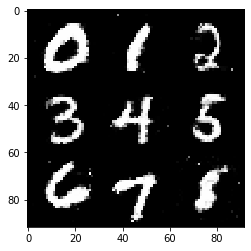

Starting epoch 30...
g_loss: 0.6775864362716675, d_loss: 1.3380327224731445


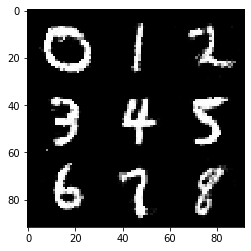

Starting epoch 31...
g_loss: 0.6627451181411743, d_loss: 1.320955753326416


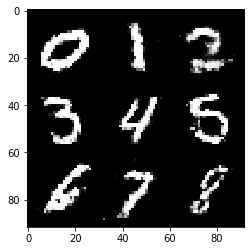

Starting epoch 32...
g_loss: 0.7314069271087646, d_loss: 1.3763457536697388


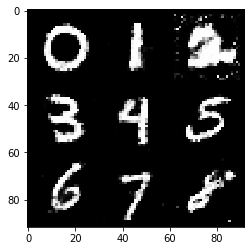

Starting epoch 33...
g_loss: 0.6873753070831299, d_loss: 1.3384687900543213


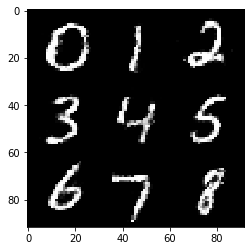

Starting epoch 34...
g_loss: 0.5503907799720764, d_loss: 1.3150230646133423


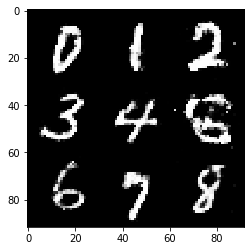

Starting epoch 35...
g_loss: 0.6355723142623901, d_loss: 1.2991762161254883


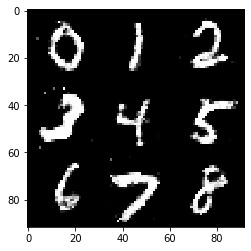

Starting epoch 36...
g_loss: 0.6564527750015259, d_loss: 1.289386510848999


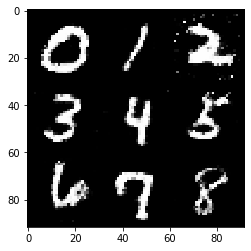

Starting epoch 37...
g_loss: 0.679742693901062, d_loss: 1.3385391235351562


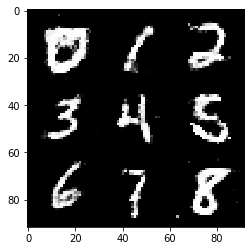

Starting epoch 38...
g_loss: 0.6064780950546265, d_loss: 1.3436596393585205


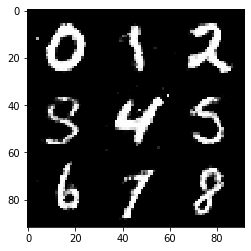

Starting epoch 39...
g_loss: 0.6289451122283936, d_loss: 1.3679689168930054


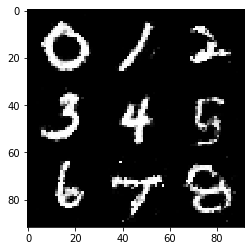

Starting epoch 40...
g_loss: 0.5337414741516113, d_loss: 1.3389475345611572


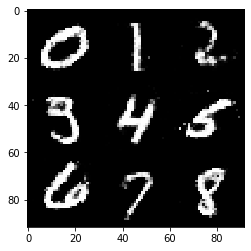

Starting epoch 41...
g_loss: 0.6090065836906433, d_loss: 1.3538455963134766


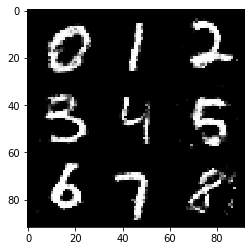

Starting epoch 42...
g_loss: 0.7150598168373108, d_loss: 1.3042080402374268


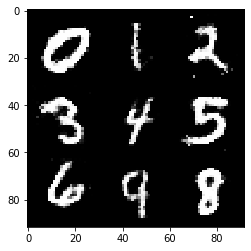

Starting epoch 43...
g_loss: 0.7374906539916992, d_loss: 1.3466979265213013


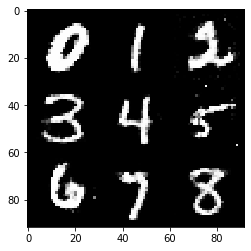

Starting epoch 44...
g_loss: 0.668460488319397, d_loss: 1.3812000751495361


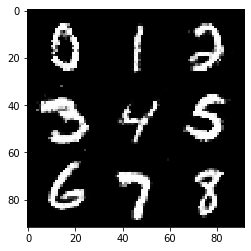

Starting epoch 45...
g_loss: 0.6168011426925659, d_loss: 1.316574215888977


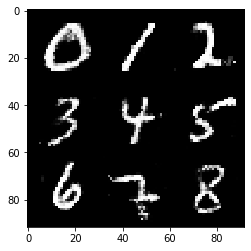

Starting epoch 46...
g_loss: 0.6194918155670166, d_loss: 1.339390754699707


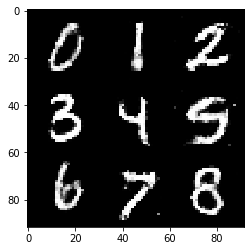

Starting epoch 47...
g_loss: 0.5923653841018677, d_loss: 1.3239209651947021


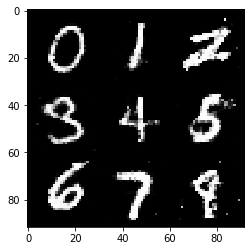

Starting epoch 48...
g_loss: 0.6910831928253174, d_loss: 1.3409559726715088


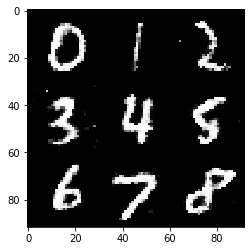

Starting epoch 49...
g_loss: 0.6626237630844116, d_loss: 1.2999764680862427


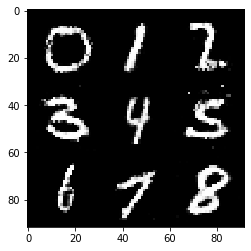

Starting epoch 50...
g_loss: 0.6340402364730835, d_loss: 1.352853775024414


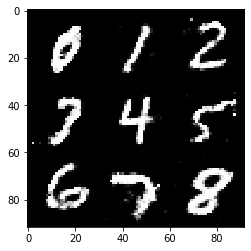

Starting epoch 51...
g_loss: 0.8202842473983765, d_loss: 1.326964020729065


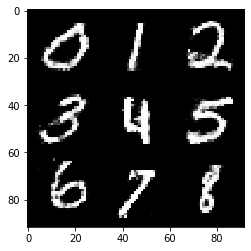

Starting epoch 52...
g_loss: 0.5620399713516235, d_loss: 1.3572351932525635


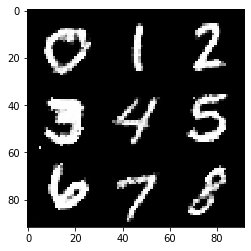

Starting epoch 53...
g_loss: 0.6182488203048706, d_loss: 1.3498713970184326


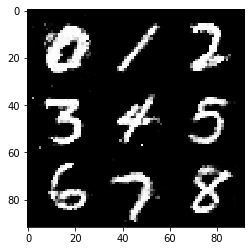

Starting epoch 54...
g_loss: 0.579079806804657, d_loss: 1.363401174545288


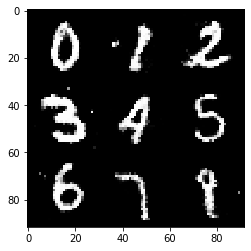

Starting epoch 55...
g_loss: 0.6749650239944458, d_loss: 1.3551967144012451


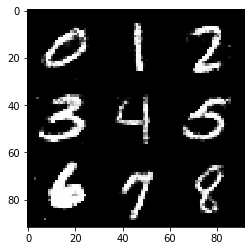

Starting epoch 56...
g_loss: 0.6647591590881348, d_loss: 1.3688267469406128


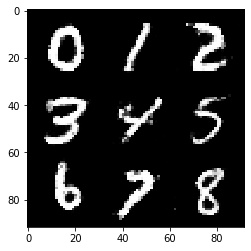

Starting epoch 57...
g_loss: 0.7461403012275696, d_loss: 1.3986144065856934


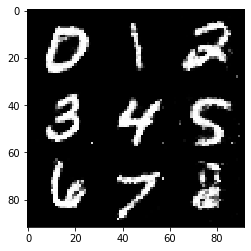

Starting epoch 58...
g_loss: 0.6454169154167175, d_loss: 1.3299510478973389


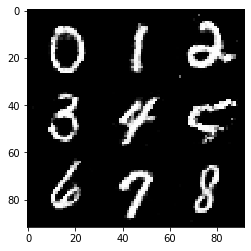

Starting epoch 59...
g_loss: 0.7554630041122437, d_loss: 1.3225388526916504


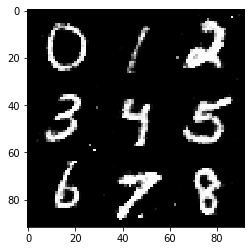

Starting epoch 60...
g_loss: 0.6860833168029785, d_loss: 1.2931551933288574


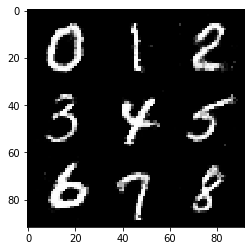

Starting epoch 61...
g_loss: 0.6821138858795166, d_loss: 1.2940200567245483


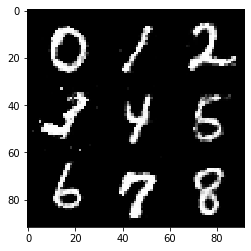

Starting epoch 62...
g_loss: 0.6565398573875427, d_loss: 1.3409518003463745


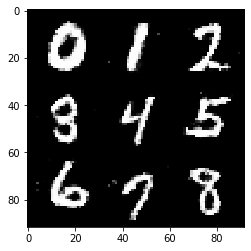

Starting epoch 63...
g_loss: 0.6822149753570557, d_loss: 1.3692548274993896


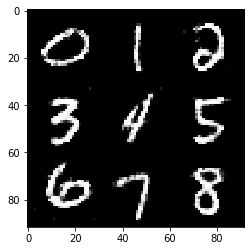

Starting epoch 64...
g_loss: 0.6812968850135803, d_loss: 1.3754498958587646


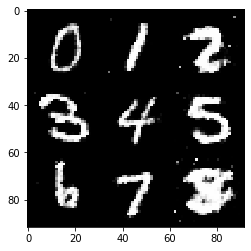

Starting epoch 65...
g_loss: 0.6428657174110413, d_loss: 1.3353843688964844


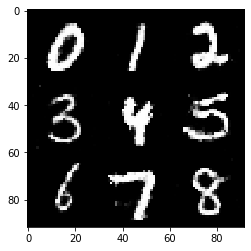

Starting epoch 66...
g_loss: 0.7721031904220581, d_loss: 1.3648526668548584


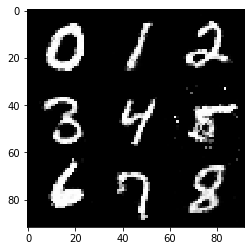

Starting epoch 67...
g_loss: 0.551705002784729, d_loss: 1.3302628993988037


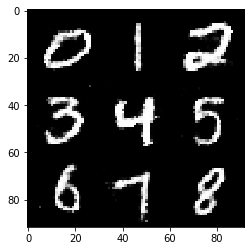

Starting epoch 68...
g_loss: 0.732795774936676, d_loss: 1.327254295349121


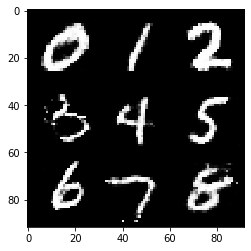

Starting epoch 69...
g_loss: 0.5896127223968506, d_loss: 1.281551480293274


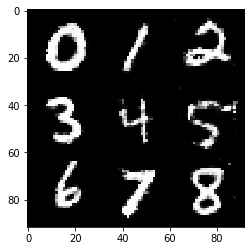

Starting epoch 70...
g_loss: 0.7989764213562012, d_loss: 1.2833648920059204


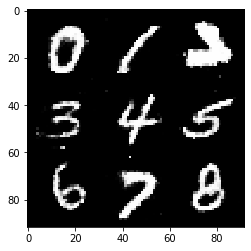

Starting epoch 71...
g_loss: 0.5878415107727051, d_loss: 1.3227484226226807


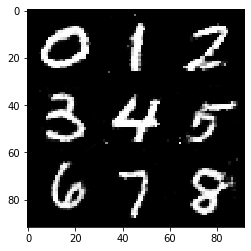

Starting epoch 72...
g_loss: 0.5193848609924316, d_loss: 1.2832825183868408


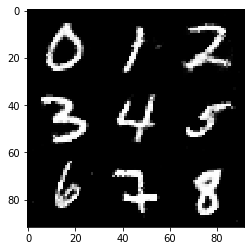

Starting epoch 73...
g_loss: 0.7689171433448792, d_loss: 1.3263344764709473


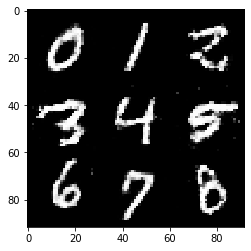

Starting epoch 74...
g_loss: 0.6434054374694824, d_loss: 1.3548221588134766


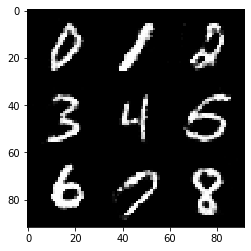

Starting epoch 75...
g_loss: 0.6058536767959595, d_loss: 1.357366681098938


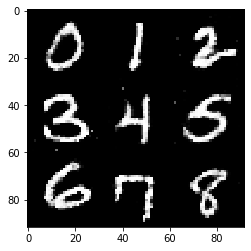

Starting epoch 76...
g_loss: 0.646246075630188, d_loss: 1.350363850593567


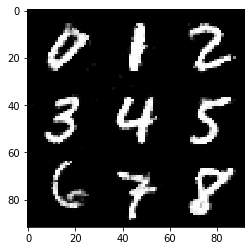

Starting epoch 77...
g_loss: 0.6772245168685913, d_loss: 1.344252347946167


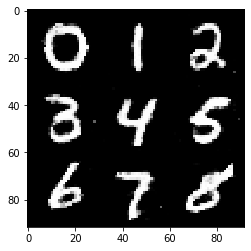

Starting epoch 78...
g_loss: 0.5985944867134094, d_loss: 1.3476063013076782


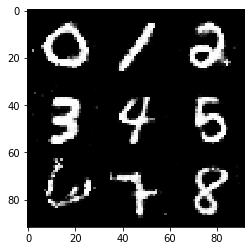

Starting epoch 79...
g_loss: 0.7226471900939941, d_loss: 1.3504014015197754


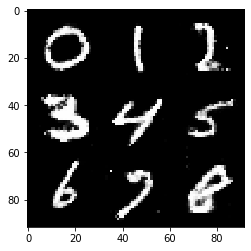

Starting epoch 80...
g_loss: 0.6388416290283203, d_loss: 1.319838285446167


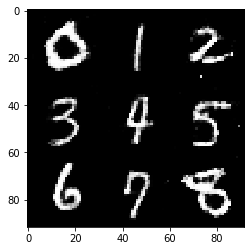

Starting epoch 81...
g_loss: 0.6780933737754822, d_loss: 1.3024845123291016


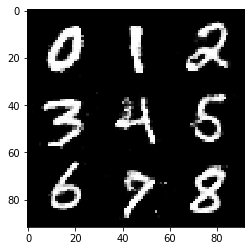

Starting epoch 82...
g_loss: 0.6003122925758362, d_loss: 1.3467413187026978


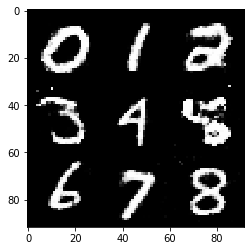

Starting epoch 83...
g_loss: 0.6872303485870361, d_loss: 1.2860782146453857


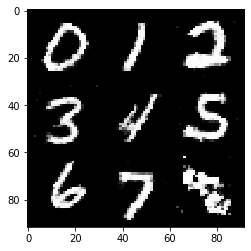

Starting epoch 84...
g_loss: 0.5710945129394531, d_loss: 1.350022315979004


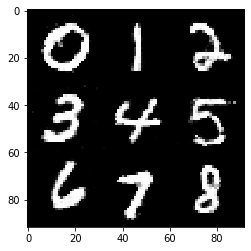

Starting epoch 85...
g_loss: 0.7027509212493896, d_loss: 1.340187430381775


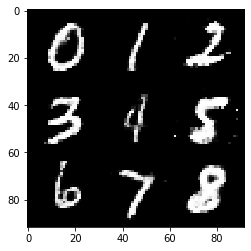

Starting epoch 86...
g_loss: 0.6643886566162109, d_loss: 1.2934587001800537


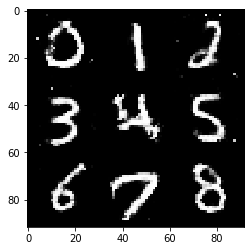

Starting epoch 87...
g_loss: 0.6587197780609131, d_loss: 1.3332583904266357


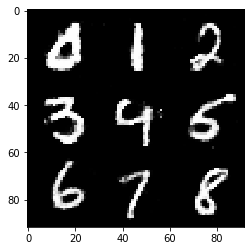

Starting epoch 88...
g_loss: 0.47977352142333984, d_loss: 1.357982873916626


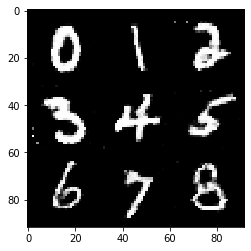

Starting epoch 89...
g_loss: 0.5548913478851318, d_loss: 1.3243244886398315


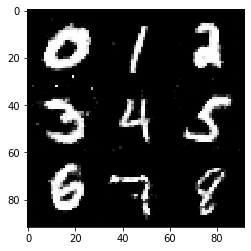

Starting epoch 90...
g_loss: 0.6697194576263428, d_loss: 1.2689027786254883


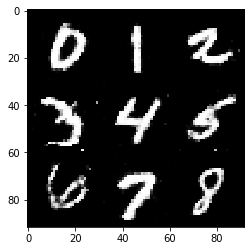

Starting epoch 91...
g_loss: 0.5912672281265259, d_loss: 1.335737943649292


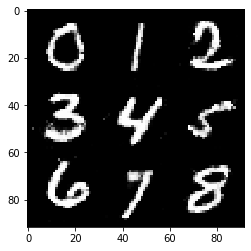

Starting epoch 92...
g_loss: 0.6455786228179932, d_loss: 1.3641443252563477


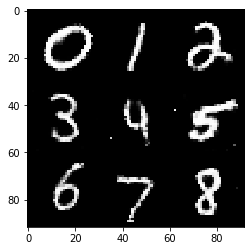

Starting epoch 93...
g_loss: 0.7090373039245605, d_loss: 1.3043389320373535


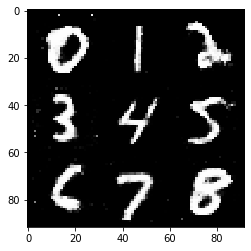

Starting epoch 94...
g_loss: 0.6780080795288086, d_loss: 1.3196220397949219


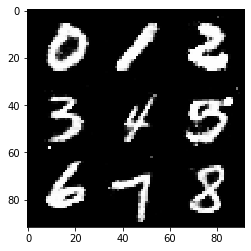

Starting epoch 95...
g_loss: 0.6821521520614624, d_loss: 1.3346059322357178


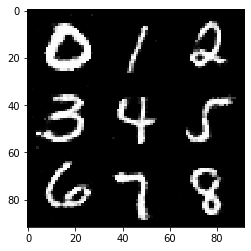

Starting epoch 96...
g_loss: 0.5908414125442505, d_loss: 1.3075461387634277


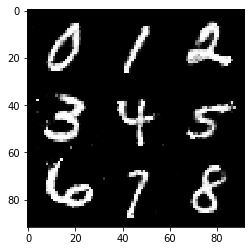

Starting epoch 97...
g_loss: 0.6770240068435669, d_loss: 1.2977824211120605


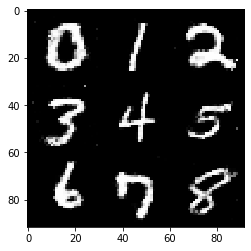

Starting epoch 98...
g_loss: 0.5968955755233765, d_loss: 1.3353233337402344


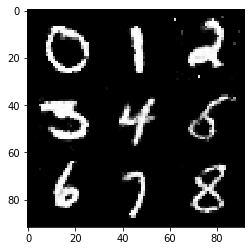

Starting epoch 99...
g_loss: 0.7409571409225464, d_loss: 1.3306782245635986


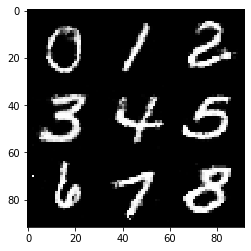

1490.0444703102112


In [10]:
num_epochs = 100
start_time = time.time()
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.LongTensor(np.random.normal(0, 1, (9, 100)))).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()
elapsed_time = time.time() - start_time
print(elapsed_time)